In [1]:
!pip install nixtla

In [2]:
!pip install yfinance

In [3]:
!pip install datasetsforecast

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nixtla import NixtlaClient

In [5]:
nixtla_client = NixtlaClient(api_key='nixtla-tok-2WhMO3zBSmvCWqvVBaBAH31mEBTR6YdwLdEurcwldlkVsex1JoxxKPAYYGXjvkPQxp1Ud77q5qvfCw7y')

microsoft = "MSFT"
start = "2018-01-01"
end = "2023-12-15"

data = yf.download(microsoft, start=start, end=end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True) 

[*********************100%%**********************]  1 of 1 completed


In [6]:
train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] <= '2022-12-31')]
test_data = data[(data['Date'] >= '2023-01-01') & (data['Date'] <= '2023-12-15')]

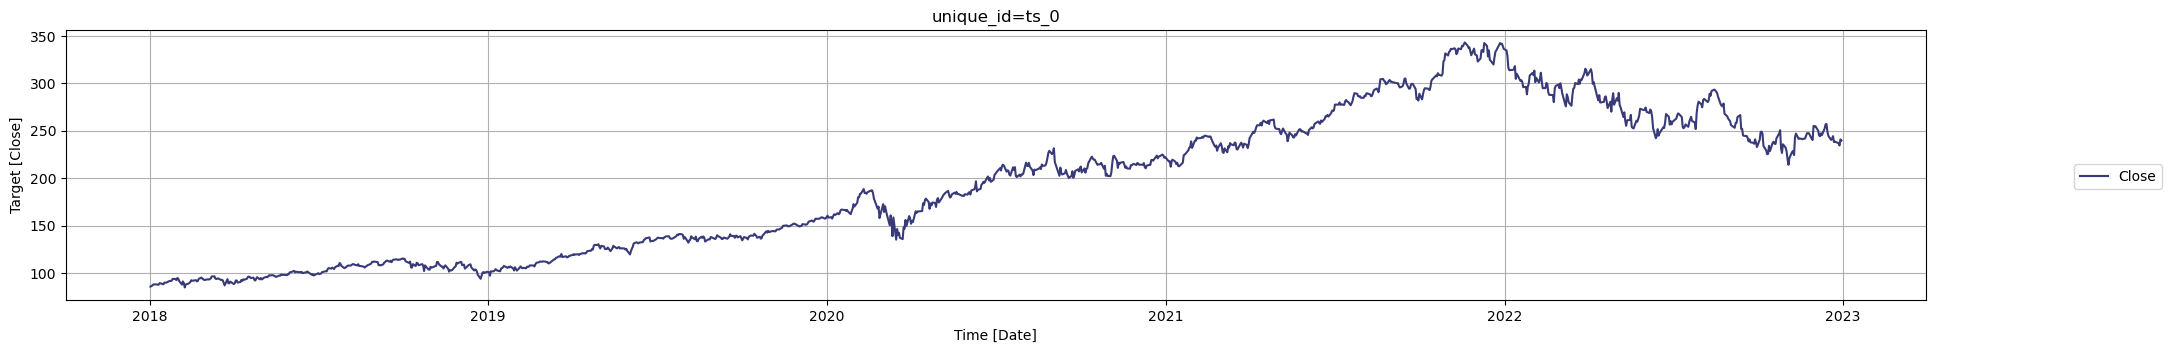

In [7]:
nixtla_client.plot(train_data, time_col='Date', target_col='Close')

In [8]:
data_forecast = nixtla_client.forecast(
    df=train_data,
    h=len(test_data),
    freq='B',
    level=[90],
    finetune_steps=10,
    model='timegpt-1-long-horizon',
    time_col='Date',
    target_col='Close'
)
data_forecast

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
0,2023-01-02,231.515289,222.159764,240.870815
1,2023-01-03,230.770218,223.077688,238.462748
2,2023-01-04,230.052200,220.385139,239.719262
3,2023-01-05,230.384384,221.080396,239.688373
4,2023-01-06,230.882141,219.314857,242.449425
...,...,...,...,...
235,2023-11-27,251.759186,213.044552,290.473820
236,2023-11-28,252.997253,214.694193,291.300314
237,2023-11-29,253.417816,214.413159,292.422473
238,2023-11-30,252.836517,210.908538,294.764497


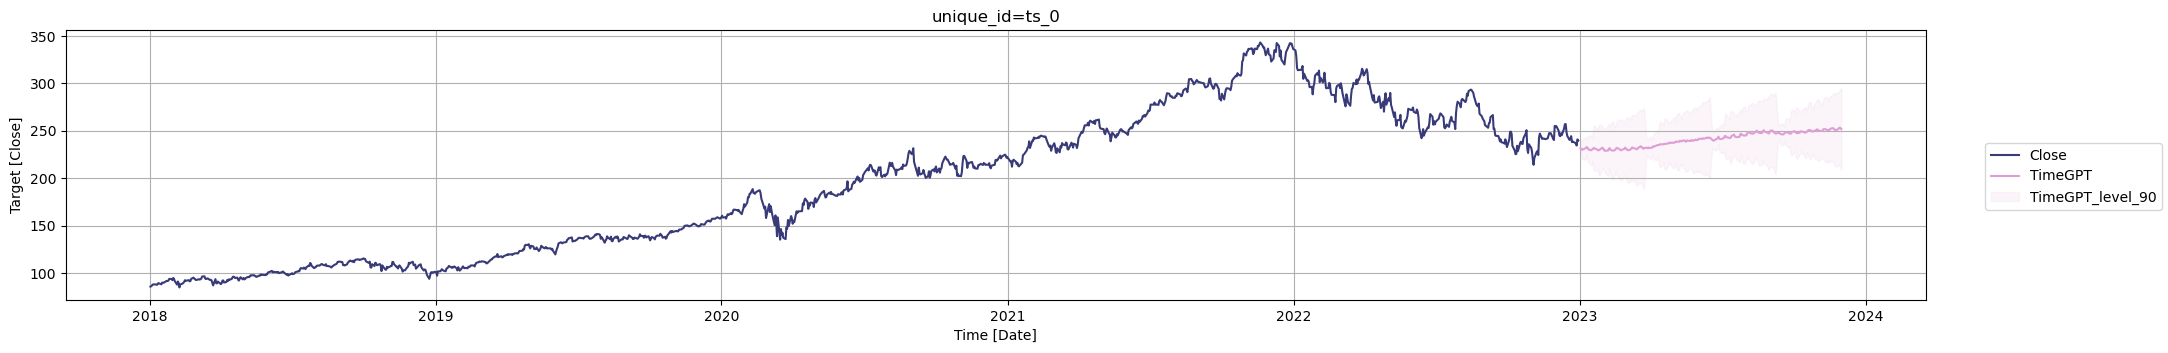

In [9]:
nixtla_client.plot(train_data, data_forecast, models=['TimeGPT'], level=[90], time_col='Date', target_col='Close')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: Open, High, Low, Adj Close, Volume


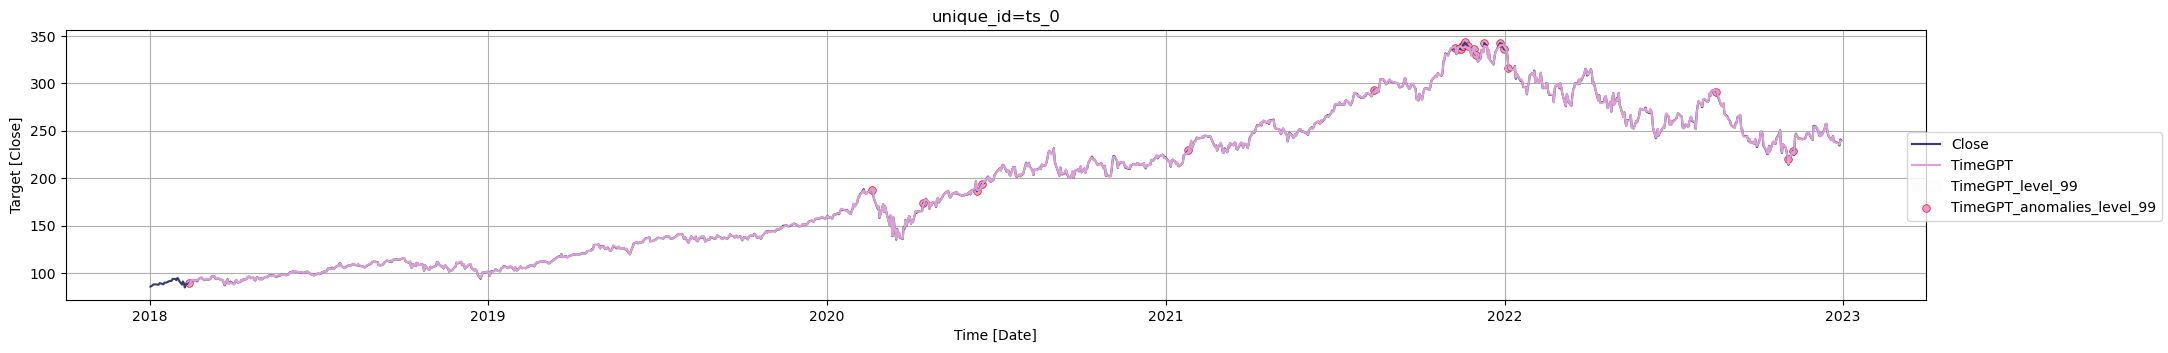

In [10]:
anomalies = nixtla_client.detect_anomalies(train_data, time_col='Date', target_col='Close', freq='B')
nixtla_client.plot(train_data, anomalies, time_col='Date', target_col='Close', plot_anomalies=True)

In [11]:
# Debugging: print the first few rows of data_forecast
print("Forecast data:")
print(data_forecast.head())

# Calculate metrics
rmse = mean_squared_error(test_data['Close'], data_forecast['TimeGPT'], squared=False)
mae = mean_absolute_error(test_data['Close'], data_forecast['TimeGPT'])

# Check for NaN values in data_forecast
if data_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the forecast data")

# Replace zero values in test_data['Close'] with NaN
test_data_non_zero = test_data.copy()
test_data_non_zero['Close'].replace(0, np.nan, inplace=True)

# Drop rows with NaN values resulting from replacement
test_data_non_zero.dropna(subset=['Close'], inplace=True)

# Ensure that the Date column is the same format
data_forecast['Date'] = pd.to_datetime(data_forecast['Date'])
test_data_non_zero['Date'] = pd.to_datetime(test_data_non_zero['Date'])

# Print the first few rows of test_data_non_zero
print("Test data non-zero:")
print(test_data_non_zero.head())

# Align forecasts with the modified test data
aligned_forecast = data_forecast[data_forecast['Date'].isin(test_data_non_zero['Date'])].copy()

# Debugging: print the first few rows of aligned_forecast
print("Aligned forecast data before setting index:")
print(aligned_forecast.head())

# Ensure the indices match
test_data_non_zero.set_index('Date', inplace=True)
aligned_forecast.set_index('Date', inplace=True)

# Debugging: print the first few rows of aligned_forecast after setting index
print("Aligned forecast data after setting index:")
print(aligned_forecast.head())

# Check again for NaN values in the aligned forecast
if aligned_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the aligned forecast data")

# Remove NaN values from aligned_forecast
aligned_forecast.dropna(subset=['TimeGPT'], inplace=True)

# Recalculate MAPE only for the dates that are present in both test_data_non_zero and aligned_forecast
common_dates = test_data_non_zero.index.intersection(aligned_forecast.index)
test_data_non_zero_common = test_data_non_zero.loc[common_dates]
aligned_forecast_common = aligned_forecast.loc[common_dates]

# Debugging: print the first few rows of the common data
print("Common test data:")
print(test_data_non_zero_common.head())
print("Common forecast data:")
print(aligned_forecast_common.head())

# Calculate MAPE
mape = np.mean(np.abs((test_data_non_zero_common['Close'].values - aligned_forecast_common['TimeGPT'].values) / test_data_non_zero_common['Close'].values)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


Forecast data:
         Date     TimeGPT  TimeGPT-lo-90  TimeGPT-hi-90
0  2023-01-02  231.515289     222.159764     240.870815
1  2023-01-03  230.770218     223.077688     238.462748
2  2023-01-04  230.052200     220.385139     239.719262
3  2023-01-05  230.384384     221.080396     239.688373
4  2023-01-06  230.882141     219.314857     242.449425
Test data non-zero:
           Date        Open        High         Low       Close   Adj Close  \
1259 2023-01-03  243.080002  245.750000  237.399994  239.580002  237.036011   
1260 2023-01-04  232.279999  232.869995  225.960007  229.100006  226.667297   
1261 2023-01-05  227.199997  227.550003  221.759995  222.309998  219.949371   
1262 2023-01-06  223.000000  225.759995  219.350006  224.929993  222.541550   
1263 2023-01-09  226.449997  231.240005  226.410004  227.119995  224.708298   

        Volume  
1259  25740000  
1260  50623400  
1261  39585600  
1262  43613600  
1263  27369800  
Aligned forecast data before setting index:
        

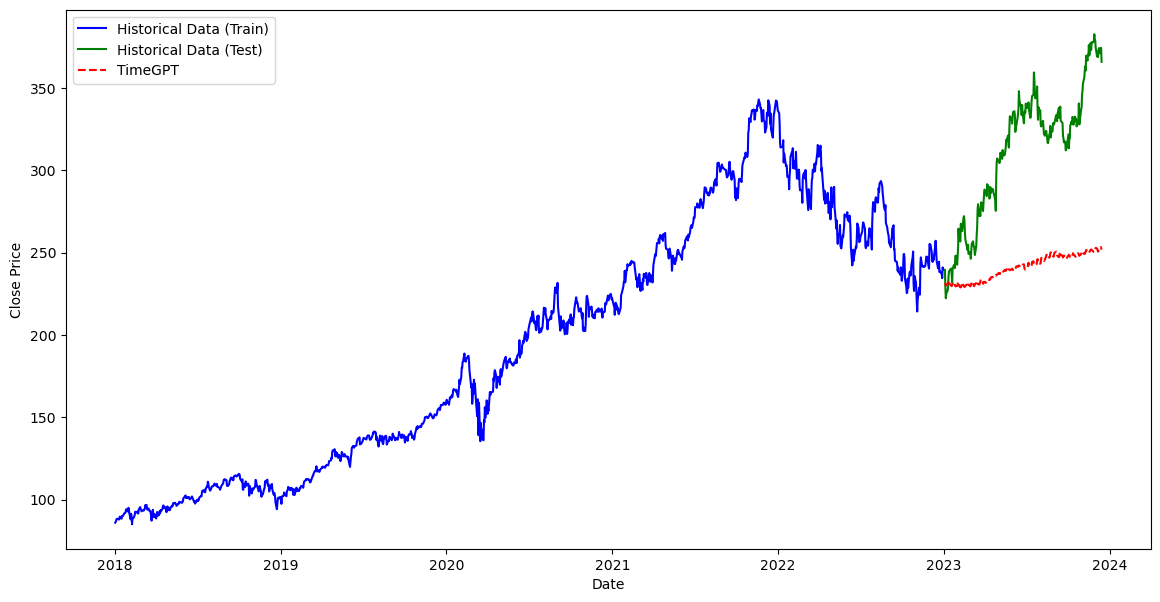

In [12]:
import matplotlib.pyplot as plt

# Визуализация на историческите данни и прогнозата
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Close'], label='Historical Data (Train)', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Historical Data (Test)', color='green')
plt.plot(test_data['Date'], data_forecast['TimeGPT'], label='TimeGPT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
highest_forecast_price = data_forecast['TimeGPT'].max()
lowest_forecast_price = data_forecast['TimeGPT'].min()

highest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmax()]['Date']
lowest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmin()]['Date']

print(f"Highest forecasted price: {highest_forecast_price} on {highest_forecast_date}")
print(f"Lowest forecasted price: {lowest_forecast_price} on {lowest_forecast_date}")

Highest forecasted price: 253.41781616210938 on 2018-12-11 00:00:00
Lowest forecasted price: 228.8255615234375 on 2018-02-05 00:00:00
